In [1]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pickle
from requests import get
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv("../data/mentions-year-top100-us.gzip", compression='gzip')
df

,GLOBALEVENTID,MentionSourceName
0,727802116,wfla.com
1,753462663,news10.com
2,776577088,abcactionnews.com
3,764175820,nbcnewyork.com
4,722603290,nbcwashington.com
5,757851077,kxan.com
6,788929854,kdvr.com
7,766869017,nbcdfw.com
8,778705342,wsvn.com
9,744063976,pix11.com


In [4]:
# distribution of nb of articles by sources
nb_articles = df.groupby("MentionSourceName").size()
nb_articles.describe()

count    8.300000e+01
mean     1.325173e+05
std      3.471676e+05
min      3.700000e+01
25%      1.074450e+04
50%      2.644700e+04
75%      1.212535e+05
max      2.415235e+06
dtype: float64

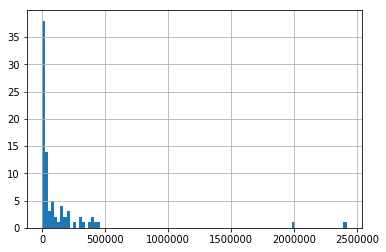

In [5]:
nb_articles.hist(bins=100)
plt.show()

In [6]:
nb_articles.sort_values(ascending=False)

MentionSourceName
reuters.com                 2415235
yahoo.com                   1983114
nbcnews.com                  440119
seattletimes.com             425986
miamiherald.com              394610
foxnews.com                  388529
stltoday.com                 384745
seattlepi.com                327661
nydailynews.com              302527
nytimes.com                  302338
chicagotribune.com           244564
latimes.com                  208850
wtop.com                     202490
bostonherald.com             195113
newsweek.com                 177229
newsmax.com                  172031
philly.com                   157981
breitbart.com                154986
politico.com                 153545
usatoday.com                 151275
huffingtonpost.com           122001
cbsnews.com                  120506
nypost.com                   116184
dailyherald.com               94158
abc13.com                     93478
npr.org                       91583
abc7news.com                  85118
newsday.co

In [12]:
sources = set(df.MentionSourceName)

In [8]:
with open("../data/sources/sources_from_top_in_gdelt.pkl", "wb") as f:
    pickle.dump(sources, f)

In [9]:
with open("../data/sources/top50_US_sources.pkl", "rb") as f:
    sources = set(pickle.load(f))

In [10]:
nb_articles[sources].sort_values(ascending=False)

MentionSourceName
nbcnews.com            440119
seattletimes.com       425986
miamiherald.com        394610
foxnews.com            388529
stltoday.com           384745
seattlepi.com          327661
nydailynews.com        302527
nytimes.com            302338
chicagotribune.com     244564
latimes.com            208850
wtop.com               202490
bostonherald.com       195113
newsweek.com           177229
newsmax.com            172031
philly.com             157981
breitbart.com          154986
politico.com           153545
usatoday.com           151275
huffingtonpost.com     122001
cbsnews.com            120506
nypost.com             116184
abc13.com               93478
npr.org                 91583
abc7news.com            85118
newsday.com             84765
boston.com              60201
mercurynews.com         57016
ktla.com                50588
denverpost.com          48105
fox2now.com             42996
kron4.com               33408
wgntv.com               31311
kdvr.com              

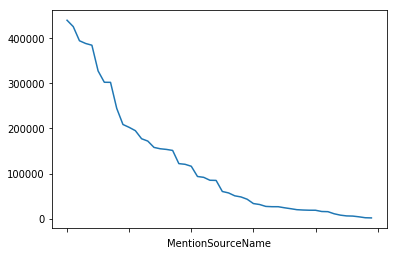

In [12]:
nb_articles[sources].sort_values(ascending=False).plot()
plt.show()

In [16]:
with open("../data/map_sources_url_to_name.pkl", "rb") as f:
    name_map = pickle.load(f)

In [22]:
def get_icon(website, errors):
    possible = ["shortcut icon", "icon", "Shortcut Icon"]
    my_header = {'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:63.0) Gecko/20100101 Firefox/63.0",}
    url = "http://"+website
    try:
        r = get(url, headers=my_header)
        soup = BeautifulSoup(r.text, 'html.parser')
        icon_link = None
        i = 0
        while icon_link is None:
            icon_link = soup.find("link", rel=possible[i])
            i+=1
        try:
            icon = get(icon_link['href'], headers=my_header)
            url = icon_link['href']
        except:
            icon = get(url + icon_link['href'], headers=my_header)
            url += icon_link['href']
        return url
    except:
        errors.append(website)

In [20]:
nb_events_covered = {}
for s in tqdm_notebook(sources):
    nb_events_covered[s] = set(df[df.MentionSourceName==s].GLOBALEVENTID)

In [23]:
nodes = []
edges = []
errors_icon = []
new_sources = sources

for source1 in tqdm_notebook(sources):
    nodes.append({  'id' : source1, 
                    'size' : int(nb_articles[source1]), 
                    'name' : name_map[source1],
                    'favicon' : get_icon(source1, errors_icon),
                 }) 
    events1 = nb_events_covered[source1]
    new_sources = new_sources - {source1}
    
    for source2 in new_sources:
        if source1==source2:
            continue
            
        events2 = nb_events_covered[source2]
        coverage_ratio = len(events1 & events2) / len(events1 | events2)
        
        edges.append({'source': source1, 'target': source2, 'weight': coverage_ratio})  

In [24]:
errors_icon

['gothamist.com',
 'seattlepi.com',
 'chicagotribune.com',
 'seattletimes.com',
 'npr.org']

In [25]:
for n in nodes:
    if n["id"] == "npr.org":
        n['favicon'] = "https://media.npr.org/templates/favicon/favicon-32x32.png"
    if n["id"] == 'http://chicagotribune.com':
        n['favicon'] = 'https://s.m.huffpost.com/assets/favicon-2020e123c064086aad150fe909c53771f862d7c76cd62f6146e81d533845fd7d.ico'

In [26]:
nodes

[{'id': 'observer.com',
  'size': 15408,
  'name': 'Observer',
  'favicon': 'http://observer.com//s2.wp.com/wp-content/themes/vip/newyorkobserver-2014/images/favicons/favicon-32x32.png'},
 {'id': 'miamiherald.com',
  'size': 394610,
  'name': 'Miami Herald ',
  'favicon': 'https://www.miamiherald.com/wps/source/images/miamiherald/favicon.png'},
 {'id': 'nytimes.com',
  'size': 302338,
  'name': 'The New York Times',
  'favicon': 'http://nytimes.com/vi-assets/static-assets/favicon-4bf96cb6a1093748bf5b3c429accb9b4.ico'},
 {'id': 'newsday.com',
  'size': 84765,
  'name': 'Newsday',
  'favicon': 'http://newsday.com/img/newsday/favicon.ico'},
 {'id': 'gothamist.com', 'size': 5620, 'name': 'Gothamist', 'favicon': None},
 {'id': 'miaminewtimes.com',
  'size': 6013,
  'name': 'Miami New Times',
  'favicon': 'http://miaminewtimes.com/theme/mia/apple-touch-icon.png'},
 {'id': 'westword.com',
  'size': 7723,
  'name': 'Westword',
  'favicon': 'http://westword.com/theme/den/apple-touch-icon.png'},

In [27]:
len(edges)

1225

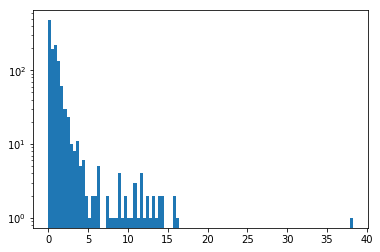

In [37]:
plt.hist([ e["weight"]*100 for e in edges ], bins = 100, log=True)
plt.show()

In [41]:
for i in np.arange(0,0.21,0.01):
    threshold = i
    filtered_edges = [ e for e in edges if e['weight'] > threshold ]
    network = {'nodes': nodes, 'edges': filtered_edges}
    with open("../data/top"+str(len(nodes))+"-US-year/threshold_"+str(int(threshold*100))+"_percent.json", "w") as f:
        json.dump(network, f, indent=2)

In [42]:
filtered_edges = [ e for e in edges if e['weight'] > 0.025 ]

In [43]:
network = {'nodes': nodes, 'edges': filtered_edges}

In [44]:
len(filtered_edges)

97